# Analytic Comparison
This notebook is a test to ensure the results from the numerical DLS model converge to the analytical results.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Set up

Both a `MagneticGeometry` and a `SimulationInputs` are needed.

In [2]:
from fusiondls import MagneticGeometry, SimulationInputs

geometry = MagneticGeometry.from_pickle("eqb_store_lores.pkl", "V10", "ou")

# Solve at these parallel positions
SparRange = np.linspace(0, geometry.S[geometry.Xpoint - 1], 3)
# Heat flux density at the x point
heat_flux = 4e8

settings = SimulationInputs(
    SparRange=SparRange,
    qpllu0=heat_flux,
    gamma_sheath=7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    Tt=1,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    nu=1e20,  # Upstream density (if constant)
    nu0=1e20,  # Upstream density (if constant)
    cz0=0.02,  # Impurity fraction (if constant)
    upstreamGrid=True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
    cooling_curve="N",  # impurity cooling function. More are available in AnalyticCoolingCurves.py
    control_variable="density",  # One of 'density', 'impurity_frac' or 'power'
    Ctol=1e-3,  # Control variable (inner) loop convergence tolerance
    Ttol=1e-3,  # Temperature (outer) loop convergence tolerance
    front_sheath=True,  # Analytical solution assumes sheath-like energy losses at the front
)

## DLS-Extended MMS test
- Higher powers make the radiation region thinner, and should mean that the answer converges on the DLS-Simple analytical solution.
- This is never going to be exact due to solver tolerances etc.


Solving...0.00...7.52...15.05...Complete in 1.5 seconds


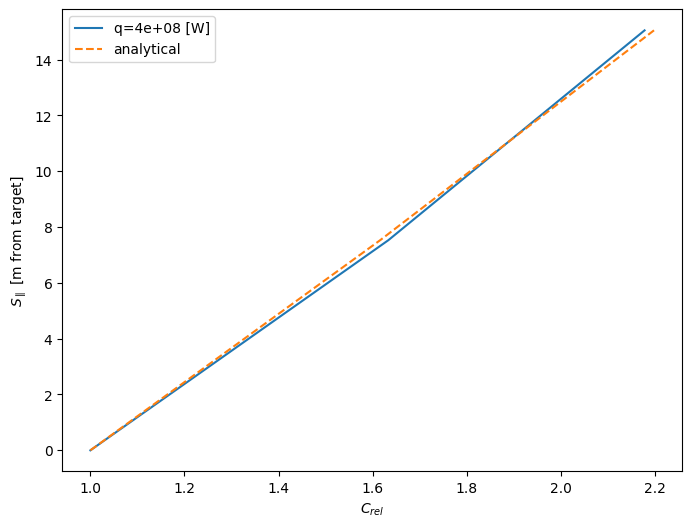

In [3]:
from fusiondls import run_dls
from fusiondls.Analytic_DLS import CfInt

results = run_dls(settings, geometry)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(
    results["cvar"] / results["cvar"][0],
    results["Splot"],
    label=f"q={heat_flux:g} [W]",
)

analytical = [
    CfInt(
        geometry.S,
        geometry.Btot,
        geometry.Sx,
        np.max(geometry.S),
        sh=s,
        kappa1=2500,
    )
    for s in SparRange
]
ax.plot(
    analytical / analytical[0],
    SparRange,
    label="analytical",
    linestyle="--",
)

ax.set_xlabel(r"$C_{rel}$")
ax.set_ylabel(r"$S_{\parallel}$ [m from target]")

ax.legend()
plt.show()

# Test

Compare the detachment window ($C_{rel}$ at the end of the scan) to the analytical result.

In [4]:
test = results["cvar"][-1] / results["cvar"][0]
reference = analytical[-1] / analytical[0]

error = abs((test - reference) / reference)

np.testing.assert_array_less(
    error, 0.01, err_msg="Convergence to analytical solution failed"
)

AssertionError: 
Arrays are not strictly ordered `x < y`
Convergence to analytical solution failed
Mismatched elements: 1 / 1 (100%)
Max absolute difference among violations: 0.00414482
Max relative difference among violations: 0.82896382
 x: array(0.009145)
 y: array(0.005)